# Classification on Greenplum Using MADlib

## Preliminaries & connection to Greenplum

A docker image or VM of Greenplum are availble online for download.  We provide links accompanying this material with some options. 

To allow us to write SQL nicely in Jupyter Notebooks, we will load the SQL magic extension

Install the sql magic extension if you haven't yet by running 'pip install ipython-sql' prior to loading the extension.  Details on the sql magic extension can be found here: https://github.com/catherinedevlin/ipython-sql.

A huge thanks to Hongdon Lee from the VMware Tanzu Data Science team for building this training material.

In [192]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


We'll now go ahead and connect to a Greenplum environment from our notebook.  Please note that your ip address, database name, and port may be different from my local demo environment.

In [193]:
%%sql 
postgresql://gpadmin@192.168.115.128:5432/demo

'Connected: gpadmin@demo'

To keep things tidy, we will store all of the tables and artifacts in this module in a schema named 'classification_madlib'.  

In [ ]:
%%sql
create schema classification_madlib;

Also, so that we don't have to keep typing 'classification_madlib.' when referencing objects, we will set the search_path to this schema for convenience.

In [194]:
%%sql
set search_path to classification_madlib;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.


[]

Let's load the data which we will be using for this module into Greenplum.  There are various ways of doing this, and here, we will make use of Greenplum's external tables functionality to load in a dataset containing information about abalone into the environment.  We will then materialize the external table locally for convenience.  

In [195]:
%%sql
drop external table if exists abalone_ext;
create external web table abalone_ext 
(
    sex text
    , length float8
    , diameter float8
    , height float8
    , whole_weight float8
    , shucked_weight float8
    , viscera_weight float8
    , shell_weight float8
    , rings float8
) 
location ('http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data') 
format 'csv' 
(NULL AS '?')
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
Done.


[]

Let's take a look at the number of records

In [196]:
%%sql
select count(*) from abalone_ext;

 * postgresql://gpadmin@192.168.115.128:5432/demo
1 rows affected.


count
4177


Let's also take a look at 10 random rows from the table

In [197]:
%%sql
select * from abalone_ext limit 10;

 * postgresql://gpadmin@192.168.115.128:5432/demo
10 rows affected.


sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15.0
M,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7.0
F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9.0
M,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10.0
I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7.0
I,0.425,0.3,0.095,0.3515,0.141,0.0775,0.12,8.0
F,0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20.0
F,0.545,0.425,0.125,0.768,0.294,0.1495,0.26,16.0
M,0.475,0.37,0.125,0.5095,0.2165,0.1125,0.165,9.0
F,0.55,0.44,0.15,0.8945,0.3145,0.151,0.32,19.0


We'll also materialize the table locally for convenience, and add in a column for ID in the process.

In [198]:
%%sql
drop table if exists abalone;
create table abalone as 
select
row_number() over() as id 
, * 
from abalone_ext;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
4177 rows affected.


[]

It looks like we have successfully materialized the table:

In [199]:
%%sql
select count(*) from abalone;

 * postgresql://gpadmin@192.168.115.128:5432/demo
1 rows affected.


count
4177


In [201]:
%%sql
select * from abalone order by id limit 10;

 * postgresql://gpadmin@192.168.115.128:5432/demo
10 rows affected.


id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15.0
2,M,0.35,0.265,0.09,0.2255,0.0995,0.0485,0.07,7.0
3,F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9.0
4,M,0.44,0.365,0.125,0.516,0.2155,0.114,0.155,10.0
5,I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7.0
6,I,0.425,0.3,0.095,0.3515,0.141,0.0775,0.12,8.0
7,F,0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20.0
8,F,0.545,0.425,0.125,0.768,0.294,0.1495,0.26,16.0
9,M,0.475,0.37,0.125,0.5095,0.2165,0.1125,0.165,9.0
10,F,0.55,0.44,0.15,0.8945,0.3145,0.151,0.32,19.0


## Data Exploration & Feature Engineering: Creating Our Response Variable

Our goal is to predict whether or not a given abalone is mature, based on using the number of rings in the abalone's shell as a proxy.  

We have a column named rings which contains this information in the table.  To approximate the abalone's age, we will set age = # rings + 1.5.

Let's also assume that a 'mature' abalone is one that is at least 10 years of age, based on our approximation above. 
We will use this column to create a 1/0 or binary column to represent maturity.  We do this using a 'case when' statement.  

For simplicity, we'll also keep only sex, diameter and shucked_weight in the table.

In [202]:
%%sql
select * from abalone limit 10;

 * postgresql://gpadmin@192.168.115.128:5432/demo
10 rows affected.


id,sex,length,diameter,height,whole_weight,shucked_weight,viscera_weight,shell_weight,rings
1,M,0.455,0.365,0.095,0.514,0.2245,0.101,0.15,15.0
3,F,0.53,0.42,0.135,0.677,0.2565,0.1415,0.21,9.0
5,I,0.33,0.255,0.08,0.205,0.0895,0.0395,0.055,7.0
7,F,0.53,0.415,0.15,0.7775,0.237,0.1415,0.33,20.0
9,M,0.475,0.37,0.125,0.5095,0.2165,0.1125,0.165,9.0
11,F,0.525,0.38,0.14,0.6065,0.194,0.1475,0.21,14.0
13,M,0.49,0.38,0.135,0.5415,0.2175,0.095,0.19,11.0
15,F,0.47,0.355,0.1,0.4755,0.1675,0.0805,0.185,10.0
17,I,0.355,0.28,0.085,0.2905,0.095,0.0395,0.115,7.0
19,M,0.365,0.295,0.08,0.2555,0.097,0.043,0.1,7.0


In [203]:
%%sql
drop table if exists abalone_v2;
create table abalone_v2 as select 
id
, LOWER(sex) as sex  
, diameter
, shucked_weight
, rings 
, case when (rings + 1.5) >= 10 then 1 else 0 end as mature 
from abalone 
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
4177 rows affected.


[]

We see that a column named 'mature' is created where it is equal to '1' when rings + 1.5 is greater or equal to 10 and '0' otherwise.

In [204]:
%%sql 
select * from abalone_v2 limit 10;

 * postgresql://gpadmin@192.168.115.128:5432/demo
10 rows affected.


id,sex,diameter,shucked_weight,rings,mature
2,m,0.265,0.0995,7.0,0
4,m,0.365,0.2155,10.0,1
6,i,0.3,0.141,8.0,0
8,f,0.425,0.294,16.0,1
10,f,0.44,0.3145,19.0,1
12,m,0.35,0.1675,10.0,1
14,f,0.405,0.2725,10.0,1
16,m,0.4,0.258,12.0,1
18,f,0.34,0.188,10.0,1
20,m,0.32,0.1705,9.0,1


## Data Exploration & Feature Engineering: Computing & Reviewing Summary Statistics

The MADlib machine learning library contains a convenient function to compute summary statistics from a table.  

We supply the source table, propose a name for a table to contain the output summary statistics.

We also supply the columns from the source table that we want to compute summary statistics on, namely diameter and shucked_weight.

The MADlib function also provides an option to compute the summary statistics grouped by a dimension of choice.  

Let's compute the summary statistics on the diameter and shucked_weight columns grouped by sex.

In [205]:
%%sql 
-- Summary statistics calculation using MADlib
drop table if exists abalone_v2_summary cascade;
select madlib.summary(
'classification_madlib.abalone_v2' 
, 'classification_madlib.abalone_v2_summary'
, 'diameter, shucked_weight'
, 'sex'
);

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
1 rows affected.


summary
"(classification_madlib.abalone_v2_summary,8,1.00742101669)"


Let's take a look at the set of statistics that are computed by the MADlib summary statistics function.  We see that there are quite a few that it has computed.

In [206]:
%%sql 
select column_name from information_schema.columns where table_name = 'abalone_v2_summary';

 * postgresql://gpadmin@192.168.115.128:5432/demo
24 rows affected.


column_name
zero_values
negative_values
positive_values
blank_values
missing_values
distinct_values
row_count
column_number
data_type
target_column


Let's take a look at a subset of these statistics, namely: row_count, missing_values, mean, std_dev, min, first_quartile, median, third_quartile, max.

We see that these metrics have been computed by MADlib grouped by 'sex' and the two columns we asked MADlib to compute these metrics on, diameter and shucked_weight.

Note that the function also returns aggregated statistics across all of the 'sex' values, and this is returned by the records with 'None' in the 'group_by_value' column below.

In [207]:
%%sql
select group_by_value
, target_column
, row_count
, missing_values
, mean
, SQRT(variance) AS std_dev
, min
, first_quartile
, median
, third_quartile
, max 
from 
abalone_v2_summary 
order by target_column, group_by_value
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
8 rows affected.


group_by_value,target_column,row_count,missing_values,mean,std_dev,min,first_quartile,median,third_quartile,max
f,diameter,1307,0,0.454732211170619,0.0709542066690581,0.195,0.41,0.465,0.505,0.65
i,diameter,1342,0,0.326494038748137,0.0881089313434407,0.055,0.27,0.335,0.39,0.55
m,diameter,1528,0,0.43928664921466,0.0843980668734395,0.11,0.395,0.455,0.5,0.63
None,diameter,4177,0,0.407881254488868,0.0992398661336559,0.055,0.35,0.425,0.48,0.65
f,shucked_weight,1307,0,0.446187834736037,0.19866321269946,0.031,0.295,0.4405,0.57325,1.488
i,shucked_weight,1342,0,0.191035022354694,0.128405320911717,0.001,0.09,0.16975,0.270375,0.7735
m,shucked_weight,1528,0,0.432946007853403,0.222999972535683,0.0065,0.276375,0.42175,0.566,1.351
None,shucked_weight,4177,0,0.359367488628203,0.221962949033219,0.001,0.186,0.336,0.502,1.488


# Exploratory Data Analysis

We will make use of Python for visualizing this data.  Let's start by saving data from Greenplum as Python objects, and then using visualization libaries in Python to generate our plots.

Note that we are using the << operator in sql magic for object assignment.

In [208]:
%%sql 
df_abalone << select sex, diameter, shucked_weight, mature 
from classification_madlib.abalone_v2;

 * postgresql://gpadmin@192.168.115.128:5432/demo
4177 rows affected.
Returning data to local variable df_abalone


We can use the result set's .DataFrame() method to work with these objects as data frames.

In [209]:
df_abalone.DataFrame()

,sex,diameter,shucked_weight,mature
0,m,0.365,0.2245,1
1,f,0.420,0.2565,1
2,i,0.255,0.0895,0
3,f,0.415,0.2370,1
4,m,0.370,0.2165,1
5,f,0.380,0.1940,1
6,m,0.380,0.2175,1
7,f,0.355,0.1675,1
8,i,0.280,0.0950,0
9,m,0.295,0.0970,0


Next, we'll use this data frame to generate a scatterplot matrix to visually asseess potential relationships between the variables.

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

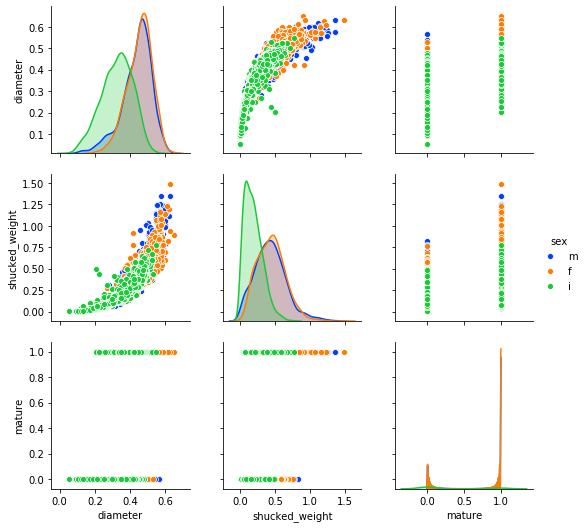

In [211]:
sns.pairplot(
            df_abalone.DataFrame()
            , diag_kind='kde'
            , hue='sex'
            , palette='bright')

plt.show()

Given that metrics like the diameter and weight of an abalone are most likely related to each outher, we see that there are some correlations between the varibles here.  

Also, it looks like the abalone in the 'infant' group, represented by the green data, may exhibit different patterns that the abalone in the 'male' and 'female' groups.

As an alternative to the visualizations, we can also compute correlation statistics between each variable pair, using a module in MADlib.

In [212]:
%%sql
drop table if exists abalone_corr, abalone_corr_summary;

select madlib.correlation(
'classification_madlib.abalone_v2'
, 'classification_madlib.abalone_corr'
,'diameter, shucked_weight, mature'
, TRUE
, 'sex'
)
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
1 rows affected.


correlation
"Summary for 'Correlation' functionOutput table = classification_madlib.abalone_corrGrouping columns: sexProducing correlation for columns: diameter,shucked_weight,matureTotal run time = ('classification_madlib.abalone_corr', 3, 0.3523099422454834)"


We then assign the output of the correlations computed in Greenplum in a Python object.

In [213]:
%%sql
df_corr << select * 
from classification_madlib.abalone_corr 
order by sex, column_position;

 * postgresql://gpadmin@192.168.115.128:5432/demo
9 rows affected.
Returning data to local variable df_corr


In [214]:
df_corr.DataFrame()

,column_position,variable,sex,diameter,shucked_weight,mature
0,1,diameter,f,1.000000,NaN,NaN
1,2,shucked_weight,f,0.878953,1.000000,NaN
2,3,mature,f,0.339494,0.237307,1.0
3,1,diameter,i,1.000000,NaN,NaN
4,2,shucked_weight,i,0.899157,1.000000,NaN
5,3,mature,i,0.575139,0.549693,1.0
6,1,diameter,m,1.000000,NaN,NaN
7,2,shucked_weight,m,0.873510,1.000000,NaN
8,3,mature,m,0.438005,0.327700,1.0


Supporting what we saw in the scatterplots, it looks like there are some strong correlations between the diameter and shucked_weight variables.

Earlier we also saw that there might be different patterns exhibited by the data depending on the sex of the abalone.  We will take a look at a boxplot to visually look into this.

Let's start by plotting the diameter variable.

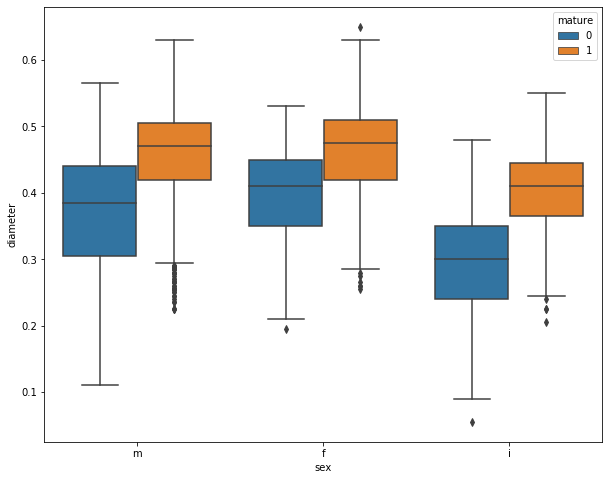

In [215]:
plt.figure(figsize=(10,8))
sns.boxplot(
data=df_abalone.DataFrame()
, x='sex'
, y='diameter'
, hue='mature'    
)
plt.show()

It looks like the mature abalone, summarized by the orange boxes, generally have a higher value of diameter comparted to the non-mature abalone (less than 10 years of age) represented by the blue boxes.

Let's also take a look at the shucked_weight variable.

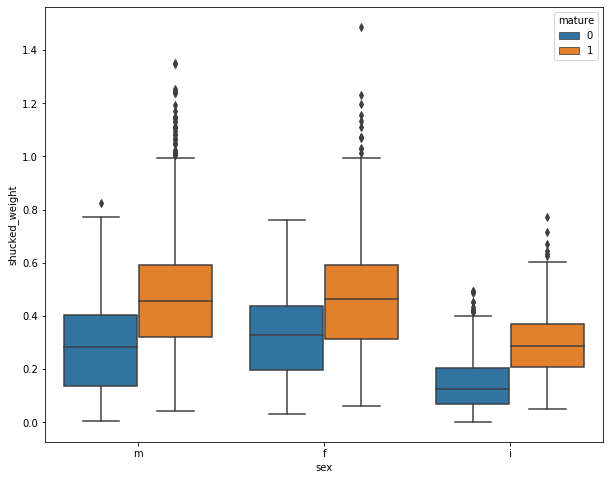

In [216]:
plt.figure(figsize=(10,8))
sns.boxplot(
data=df_abalone.DataFrame()
, x='sex'
, y='shucked_weight'
, hue='mature'    
)
plt.show()

We see here as well that the shucked_weight mature abalone are generally higher than that of abalone less than 10 years of age, which is in line with what we would generally expect biologically.

## Model Training - Classification

After exploring the data through summary statistics and visualizations, we now move forward to train a model to predict whether or not a given abalone is mature, or at least ten years in age.

One of the variables that we want to include as a predictor in our model is 'sex'.  This is a categorical variable, and MADlib contains a function to do one-hot encoding on categorical variables.

In [217]:
%%sql
select * from abalone_v2 order by id limit 5;

 * postgresql://gpadmin@192.168.115.128:5432/demo
5 rows affected.


id,sex,diameter,shucked_weight,rings,mature
1,m,0.365,0.2245,15.0,1
2,m,0.265,0.0995,7.0,0
3,f,0.42,0.2565,9.0,1
4,m,0.365,0.2155,10.0,1
5,i,0.255,0.0895,7.0,0


In [218]:
%%sql
drop table if exists abalone_onehot;
select madlib.encode_categorical_variables(
'classification_madlib.abalone_v2'        -- source table
,'classification_madlib.abalone_onehot'   -- output table name
,'sex'                             -- categorical columns to encode, in lowercase
)
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
1 rows affected.


encode_categorical_variables
""


In [219]:
%%sql
select * from abalone_onehot order by id limit 5;

 * postgresql://gpadmin@192.168.115.128:5432/demo
5 rows affected.


id,diameter,shucked_weight,rings,mature,sex_f,sex_i,sex_m
1,0.365,0.2245,15.0,1,0,0,1
2,0.265,0.0995,7.0,0,0,0,1
3,0.42,0.2565,9.0,1,1,0,0
4,0.365,0.2155,10.0,1,0,0,1
5,0.255,0.0895,7.0,0,0,1,0


We see that the function has correctly mapped the categorical columns into 3 binary columns, one for each sex.

We now split up our dataset into a training and test set.  The training set will be used to build candidate models, and the test set will be used to evaluate the accuracy and performance of the built model.  

To do this, we make use of the train_test_split() function available in MADlib.

Note that for reproducability we make use of the setseed() function in Greenplum.

In [220]:
%%sql 
drop table if exists abalone_onehot_split, abalone_onehot_split_train, abalone_onehot_split_test;

select setseed(0.1); --for reproducibilty

select madlib.train_test_split(
'classification_madlib.abalone_onehot'                   -- source table
,'classification_madlib.abalone_onehot_split'            -- output table 
, 0.8                                                    -- proportion of training set
, 0.2                                                    -- proportion of test set
, NULL                                                   -- strata definition  
, 'id, diameter, shucked_weight, sex_f, sex_i, mature'   -- columns to output
, FALSE                                                  -- sampling with replacement 
, TRUE                                                   -- separate output tables 
)
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
1 rows affected.
1 rows affected.


train_test_split
""


In [221]:
%%sql
select count(*) from abalone_onehot_split_train;

 * postgresql://gpadmin@192.168.115.128:5432/demo
1 rows affected.


count
3342


In [222]:
%%sql
select count(*) from abalone_onehot_split_test;

 * postgresql://gpadmin@192.168.115.128:5432/demo
1 rows affected.


count
835


In [223]:
835/(835+3342)

0.19990423749102226

Looks like the rough 20% and 80% split has worked out.  Let's also take a look at a couple of records from the training data table.

In [224]:
%%sql
select * from abalone_onehot_split_train 
order by id 
limit 5;

 * postgresql://gpadmin@192.168.115.128:5432/demo
5 rows affected.


id,diameter,shucked_weight,sex_f,sex_i,mature
2,0.265,0.0995,0,0,0
3,0.42,0.2565,1,0,1
4,0.365,0.2155,0,0,1
5,0.255,0.0895,0,1,0
6,0.3,0.141,0,1,0


We are now ready to train a model to predict whether or not a given abalone is mature, or equivalently, at least ten years in age.

We decide to use MADlib's logistic regression module to do this.

In [225]:
%%sql 
drop table if exists madlib_logit_fitted, madlib_logit_fitted_summary;

select madlib.logregr_train(
'classification_madlib.abalone_onehot_split_train'                -- source table 
, 'classification_madlib.madlib_logit_fitted'                     -- name of output table
, 'mature'                                                        -- response variable
, 'array[1, diameter, shucked_weight, sex_f, sex_i]'              -- explanatory variables, including the intercept(1)
, NULL                                                            -- grouping columns
, 500                                                             -- max number of iterations
)
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
1 rows affected.


logregr_train
""


Let's take a look at the results of the logistic regression model.

In [226]:
%%sql 
drop table if exists madlib_logit_fitted_summary;
create table madlib_logit_fitted_summary as 
select unnest(b.var) as var_nm 
, unnest(b.coef) as coef
, unnest(b.std_err) as std_err
, unnest(b.z_stats) as z_stats
, unnest(b.p_values) as p_values
, unnest(b.odds_ratios) as odds_ratios
from 
(select array['1_intercept', 'diameter', 'shucked_weight', 'sex_f', 'sex_i'] as var
 , a.* 
 from madlib_logit_fitted a
) b
;

select * from madlib_logit_fitted_summary order by 1;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
5 rows affected.
5 rows affected.


var_nm,coef,std_err,z_stats,p_values,odds_ratios
1_intercept,-6.76900625822974,0.427347686922907,-15.8395762171304,1.65935344316121e-56,0.00114883572989055
diameter,22.660863889844,1.45698551288264,15.5532527190402,1.51226239145872e-54,6942056476.57922
sex_f,0.0279901077214831,0.129750890438938,0.215721893135335,0.829204534740612,1.02838551129521
sex_i,-1.22528378996405,0.120196042426598,-10.1940443730692,2.10807489681349e-24,0.293674346664344
shucked_weight,-3.12751269488223,0.592466882969353,-5.27879749026244,1.30034417952345e-07,0.0438266720999464


## Model Evaluation & Prediciton

We evaluate the accuracy of the model that we've trained in the following section.  

We start by computed the predicted values based on the trained model on the test data set.  We make use of MADlib's prediction function for logistic regression here.

In [227]:
%%sql
drop table if exists madlib_logit_predicted_class;
create table madlib_logit_predicted_class as (
  select
    test.id
    , test.diameter
    , test.shucked_weight
    , test.sex_f
    , test.sex_i
    , madlib.logregr_predict_prob(model.coef, array[1, diameter, shucked_weight, sex_f, sex_i]) as pred_proba
    , madlib.logregr_predict(model.coef, array[1, diameter, shucked_weight, sex_f, sex_i])::int as mature_pred 
    , test.mature
  from abalone_onehot_split_test test
    , madlib_logit_fitted model
  order by test.id
)
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
835 rows affected.


[]

In [228]:
%%sql
select * from madlib_logit_predicted_class order by id limit 10;

 * postgresql://gpadmin@192.168.115.128:5432/demo
10 rows affected.


id,diameter,shucked_weight,sex_f,sex_i,pred_proba,mature_pred,mature
1,0.365,0.2245,0,0,0.689992120179034,1,1
8,0.425,0.294,1,0,0.877650019260448,1,1
9,0.37,0.2165,0,0,0.718777742822688,1,1
16,0.4,0.258,0,0,0.815844163269398,1,1
22,0.275,0.08,0,1,0.117870376512508,0,1
24,0.415,0.318,1,0,0.841401529932681,1,1
31,0.47,0.3935,0,0,0.93406788863655,1,1
32,0.56,0.6055,1,0,0.982965924756674,1,1
33,0.525,0.5515,0,0,0.967802026506753,1,1
37,0.475,0.5305,1,0,0.914020862143357,1,1


We made use of two versions of the MADlib predict function for logistic regression.  One version returns the predicted probability and the other version returns the predicted class.  The later is equal to '1' if the predicted probability is greater or equal to 0.5.

We will also compute the confusion matrix to sum up and check how the model is doing overall by using MADlib's function here.

In [229]:
%%sql
drop table if exists madlib_logit_conf_mat;

select madlib.confusion_matrix
('classification_madlib.madlib_logit_predicted_class' -- source table
 , 'classification_madlib.madlib_logit_conf_mat' -- output table
 , 'mature_pred'              -- predicted value
 , 'mature' )                 -- actual value
;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
1 rows affected.


confusion_matrix
""


In [230]:
%%sql
select
  class as actual
  , confusion_arr[1] as predicted_0
  , confusion_arr[2] as predicted_1
from madlib_logit_conf_mat;

 * postgresql://gpadmin@192.168.115.128:5432/demo
2 rows affected.


actual,predicted_0,predicted_1
1,37,509
0,199,90


In addition to the confusion matrix, we can make use of the numbers contained in it to compute standard methods of assessing model quality such as precision and recall.

In [231]:
%%sql
df_madlib << select * from madlib_logit_predicted_class;

 * postgresql://gpadmin@192.168.115.128:5432/demo
835 rows affected.
Returning data to local variable df_madlib


In [232]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

y_true = df_madlib.DataFrame()['mature']
y_pred = df_madlib.DataFrame()['mature_pred']

# performance metrics
precision, recall, fscore, support = \
    precision_recall_fscore_support(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)

print('Precision: %.3f' %precision[1]); print('Recall   : %.3f' %recall[1])
print('F1-Score : %.3f' %fscore[1]); print('Accuracy : %.3f' %accuracy)

Precision: 0.850
Recall   : 0.932
F1-Score : 0.889
Accuracy : 0.848


In general, we see that we have a model that fits fairly well.  

As another way to assess model fit, we can compute the area under the ROC curve and also visually plot an ROC curve. 

We'll begin by simply computing the area under the ROC curve using a MADlib function.

In [233]:
%%sql
drop table if exists madlib_logit_auc;
select madlib.area_under_roc(
  'classification_madlib.madlib_logit_predicted_class' -- source table
  , 'classification_madlib.madlib_logit_auc'           -- output table
  , 'pred_proba'                                       -- predicted probability
  , 'mature'                                           -- actual value
);

select * from madlib_logit_auc;

 * postgresql://gpadmin@192.168.115.128:5432/demo
Done.
1 rows affected.
1 rows affected.


area_under_roc
0.89063272367770637666937766961988415275610


Let's now visually plot the ROC curve

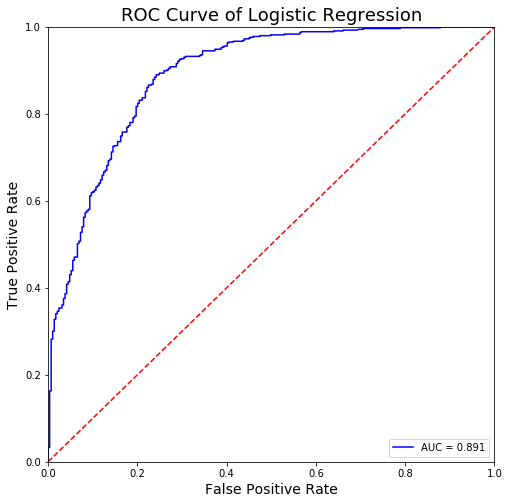

In [234]:
# calculate fpr, tpr, AUC
import sklearn.metrics as metrics

y = df_madlib.DataFrame()['mature']
pred_proba = df_madlib.DataFrame()['pred_proba']
fpr, tpr, threshold = metrics.roc_curve(y, pred_proba)
AUC = metrics.auc(fpr, tpr)

# plotting ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 8))
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % AUC)
plt.title(('ROC Curve of Logistic Regression'), 
             fontsize=18)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.show()